# GradCAM Visualization for Trained Model

This notebook loads the trained DenseNet-121 model and visualizes GradCAM activations on test images.

In [1]:
# Import Required Libraries
%matplotlib inline

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
from tqdm import tqdm

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as F

import sys
sys.path.append('..')
from trainers.basic_trainer import BasicTrainingModule
from models.generic_model import GenericSE
import utils

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

IMG_SIZE = 224

## Load the Trained Model

Load the model from the checkpoint file.

In [2]:
# Load model checkpoint
checkpoint_path = '../checkpoints/best_test_peak.ckpt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model instance with SE blocks (same architecture as training)
channels = [16]*1 + [32]*5
model = GenericSE(channels=channels)
checkpoint = torch.load(checkpoint_path, map_location='cpu')
state_dict = checkpoint['state_dict']

# Filter out only the inner model weights
model_state_dict = {k.replace("model.", ""): v for k, v in state_dict.items() if k.startswith("model.")}
model.load_state_dict(model_state_dict)
model = model.to(device)
model.eval()

print(f"Model loaded from {checkpoint_path}")
print(f"Device: {device}")


print("Model: ", model)

Model loaded from ../checkpoints/best_test_peak.ckpt
Device: cpu
Model:  GenericSE(
  (backbone): Sequential(
    (0): DepthwiseSeparableConv(
      (layer): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ReLU()
    (2): DepthwiseSeparableConv(
      (layer): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_r

/tmp/ipykernel_2909508/1613968273.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


## Load Test Dataset and Evaluate Accuracy

In [3]:
# Prepare test data
IMG_SIZE = 224
test_transformation = F.Compose([
    F.ToImage(),
    F.ToDtype(torch.float32, scale=True),
    F.Resize(size=(IMG_SIZE, IMG_SIZE)),
])

test_folder = os.path.expanduser('/ghome/mcv/datasets/C3/2425/MIT_small_train_1/test')
data_test = ImageFolder(test_folder, transform=test_transformation)
test_loader = DataLoader(data_test, batch_size=32, shuffle=False, num_workers=4)

print(f"Test dataset loaded: {len(data_test)} images")
print(f"Classes: {data_test.classes}")

Test dataset loaded: 2288 images
Classes: ['Opencountry', 'coast', 'forest', 'highway', 'inside_city', 'mountain', 'street', 'tallbuilding']


In [4]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    pbar = tqdm(test_loader, desc="Evaluating", unit="batch")
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Opcional: Actualizar la barra con el accuracy actual
        current_acc = 100 * correct / total
        pbar.set_postfix(acc=f"{current_acc:.2f}%")

test_accuracy = correct / total
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Correct predictions: {correct}/{total}")

Evaluating:  42%|████▏     | 30/72 [00:03<00:04,  8.55batch/s, acc=87.08%]


KeyboardInterrupt: 

## Select Random Test Image and Visualize GradCAM

Showing image index: 2232
Selected image: /ghome/mcv/datasets/C3/2425/MIT_small_train_1/test/tallbuilding/urb792.jpg
True class: tallbuilding (label: 7)
Predicted class: tallbuilding (label: 7)
Confidence: 0.9850


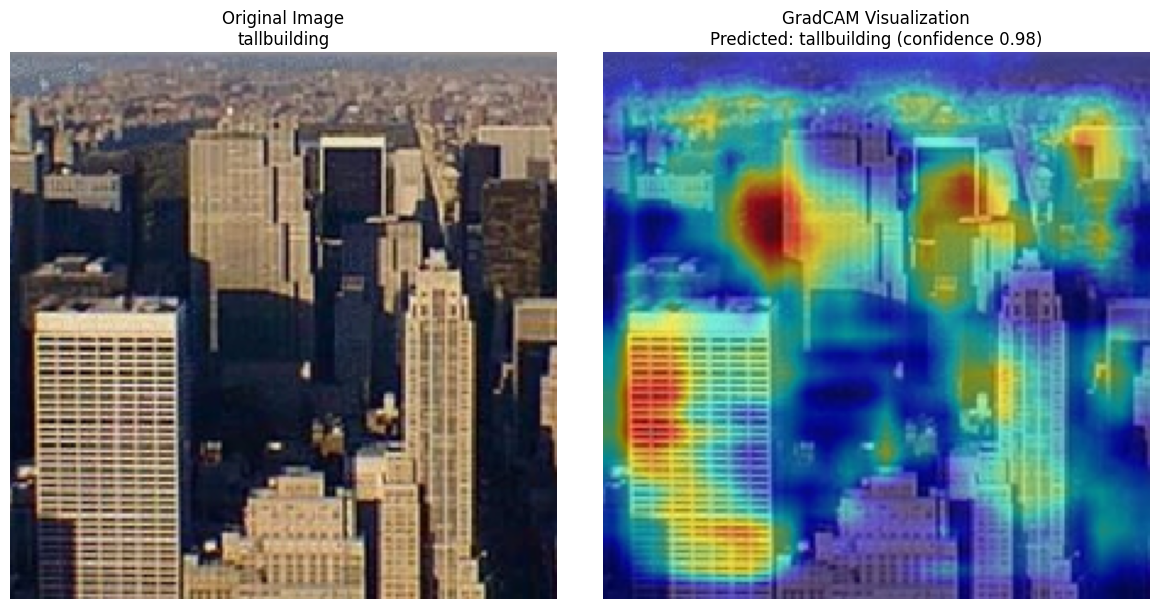

In [ ]:
# Select a random test image
#idx = random.randint(0, len(data_test) - 1)
idx = 2232
print("Showing image index:", idx)


img_path, label = data_test.samples[idx]
class_name = data_test.classes[label]

print(f"Selected image: {img_path}")
print(f"True class: {class_name} (label: {label})")

# Load and preprocess image
img = Image.open(img_path).convert('RGB')
img_tensor = test_transformation(img).unsqueeze(0).to(device)

# Get prediction
with torch.no_grad():
    output = model(img_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = output.argmax(1).item()
    confidence = probabilities[0, predicted_class].item()

predicted_name = data_test.classes[predicted_class]
print(f"Predicted class: {predicted_name} (label: {predicted_class})")
print(f"Confidence: {confidence:.4f}")


# Generate GradCAM visualization
target_layer = [model.backbone[15]] #last conv layer
targets = [ClassifierOutputTarget(predicted_class)]

# Prepare image for GradCAM overlay (needs to be numpy array in [0, 1] range)
img_array = np.array(img.resize((IMG_SIZE, IMG_SIZE)))
img_normalized = img_array.astype(np.float32) / 255.0

# Extract GradCAM
grad_cams = model.extract_grad_cam(
    input_image=img_tensor, 
    target_layer=target_layer, 
    targets=targets
)

# Create visualization
visualization = show_cam_on_image(img_normalized, grad_cams, use_rgb=True)

# Display GradCAM
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img_normalized)
axes[0].set_title(f'Original Image\n{class_name}')
axes[0].axis('off')

axes[1].imshow(visualization)
axes[1].set_title(f'GradCAM Visualization\nPredicted: {predicted_name} (confidence {confidence:.2f})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Visualize GradCAM for One Sample Per Class

Generate one random sample for each class in the dataset.

Selected indices per class:
  Class 0 (Opencountry): index 174
  Class 1 (coast): index 502
  Class 2 (forest): index 749
  Class 3 (highway): index 1003
  Class 4 (inside_city): index 1330
  Class 5 (mountain): index 1468
  Class 6 (street): index 1763
  Class 7 (tallbuilding): index 2176


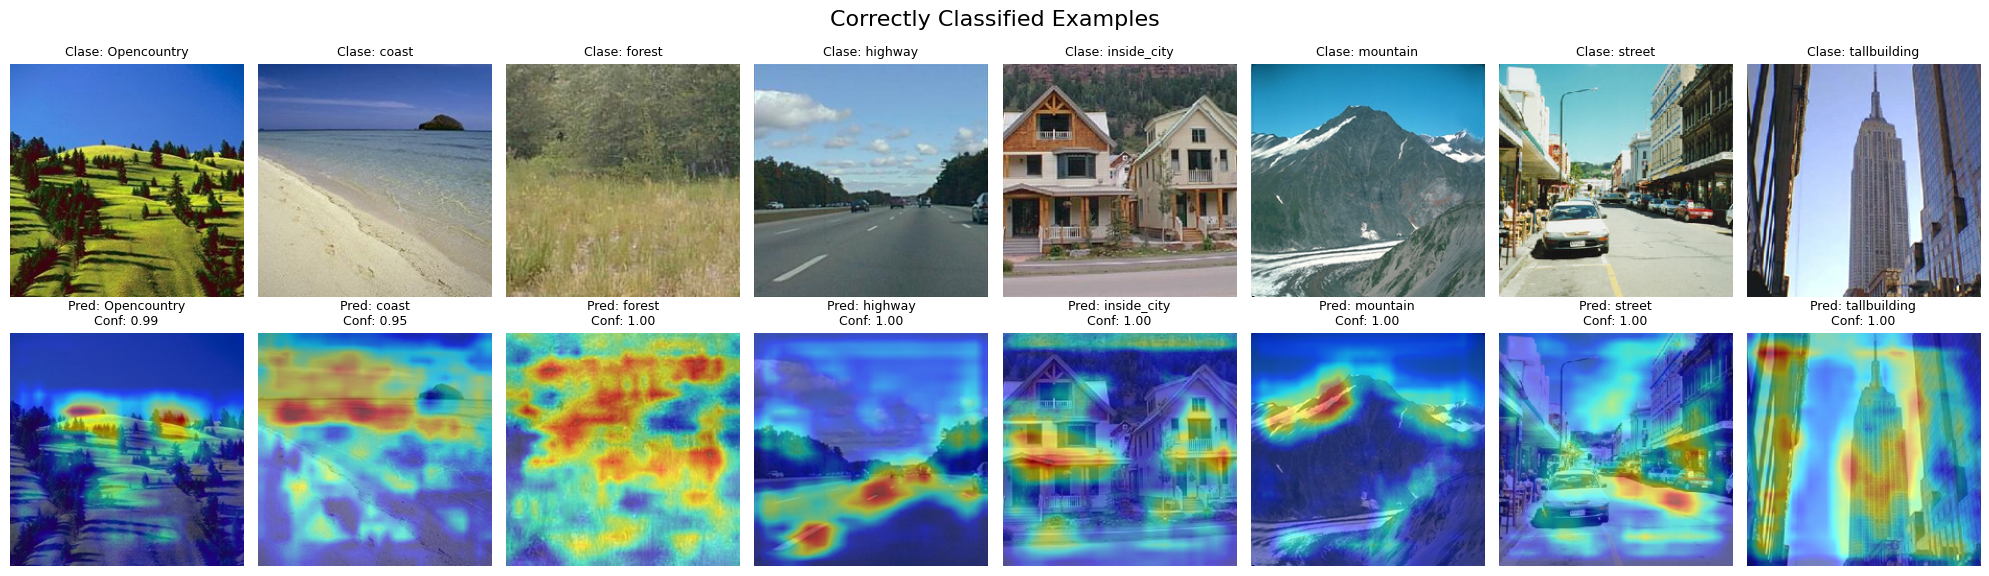

In [ ]:
num_classes = len(data_test.classes)


class_indices = {i: [] for i in range(num_classes)}
for idx, (_, label) in enumerate(data_test.samples):
    class_indices[label].append(idx)

selected_indices = []
for class_id in range(num_classes):
    if len(class_indices[class_id]) > 0:
        random_idx = random.choice(class_indices[class_id])
        selected_indices.append(random_idx)
    else:
        selected_indices.append(None)

selected_indices = [174, 502, 749, 1003, 1330, 1468, 1763, 2176]

print("Selected indices per class:")
for class_id, idx in enumerate(selected_indices):
    if idx is not None:
        print(f"  Class {class_id} ({data_test.classes[class_id]}): index {idx}")

# Definimos el número de imágenes (asumiendo 8 para las 8 clases)
num_images = len([idx for idx in selected_indices if idx is not None])
cols = num_images  # Las 8 columnas
rows = 2           # Una fila para original, otra para GradCAM

fig, axes = plt.subplots(rows, cols, figsize=(2.5 * cols, 6))

# Nos aseguramos de que axes sea siempre una matriz 2D para poder usar [row, col]
if cols == 1:
    axes = axes.reshape(2, 1)

plot_idx = 0
for class_id, idx in enumerate(selected_indices):
    if idx is None:
        continue
    
    # --- CARGA Y PROCESAMIENTO ---
    img_path, label = data_test.samples[idx]
    class_name = data_test.classes[label]
    
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transformation(img).unsqueeze(0).to(device)
    
    # Inferencia
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class = output.argmax(1).item()
        confidence = probabilities[0, predicted_class].item()
    
    predicted_name = data_test.classes[predicted_class]
    
    # Preparar imagen para visualizar
    img_array = np.array(img.resize((IMG_SIZE, IMG_SIZE)))
    img_normalized = img_array.astype(np.float32) / 255.0
    
    # --- GENERAR GRAD-CAM ---
    targets = [ClassifierOutputTarget(predicted_class)]
    grad_cams = model.extract_grad_cam(
        input_image=img_tensor,
        target_layer=target_layer,
        targets=targets
    )
    visualization = show_cam_on_image(img_normalized, grad_cams, use_rgb=True)
    
    # originals
    axes[0, plot_idx].imshow(img_normalized)
    axes[0, plot_idx].set_title(f'Clase: {class_name}', fontsize=9)
    axes[0, plot_idx].axis('off')
    
    # GradCAM
    axes[1, plot_idx].imshow(visualization)
    axes[1, plot_idx].set_title(f'Pred: {predicted_name}\nConf: {confidence:.2f}', fontsize=9)
    axes[1, plot_idx].axis('off')
    
    plot_idx += 1

plt.suptitle('Correctly Classified Examples', fontsize = 16)
plt.tight_layout()
plt.show()

## Visualize GradCAM for Misclassified Samples

For each class, find a misclassified sample and show GradCAM for both the Ground Truth class and the Predicted class (with their confidences).

Selected indices per class:
  Class 0 (Opencountry): index 6
  Class 1 (coast): index 362
  Class 2 (forest): index 683
  Class 3 (highway): index 948
  Class 4 (inside_city): index 1164
  Class 5 (mountain): index 1420
  Class 6 (street): index 1742
  Class 7 (tallbuilding): index 1992


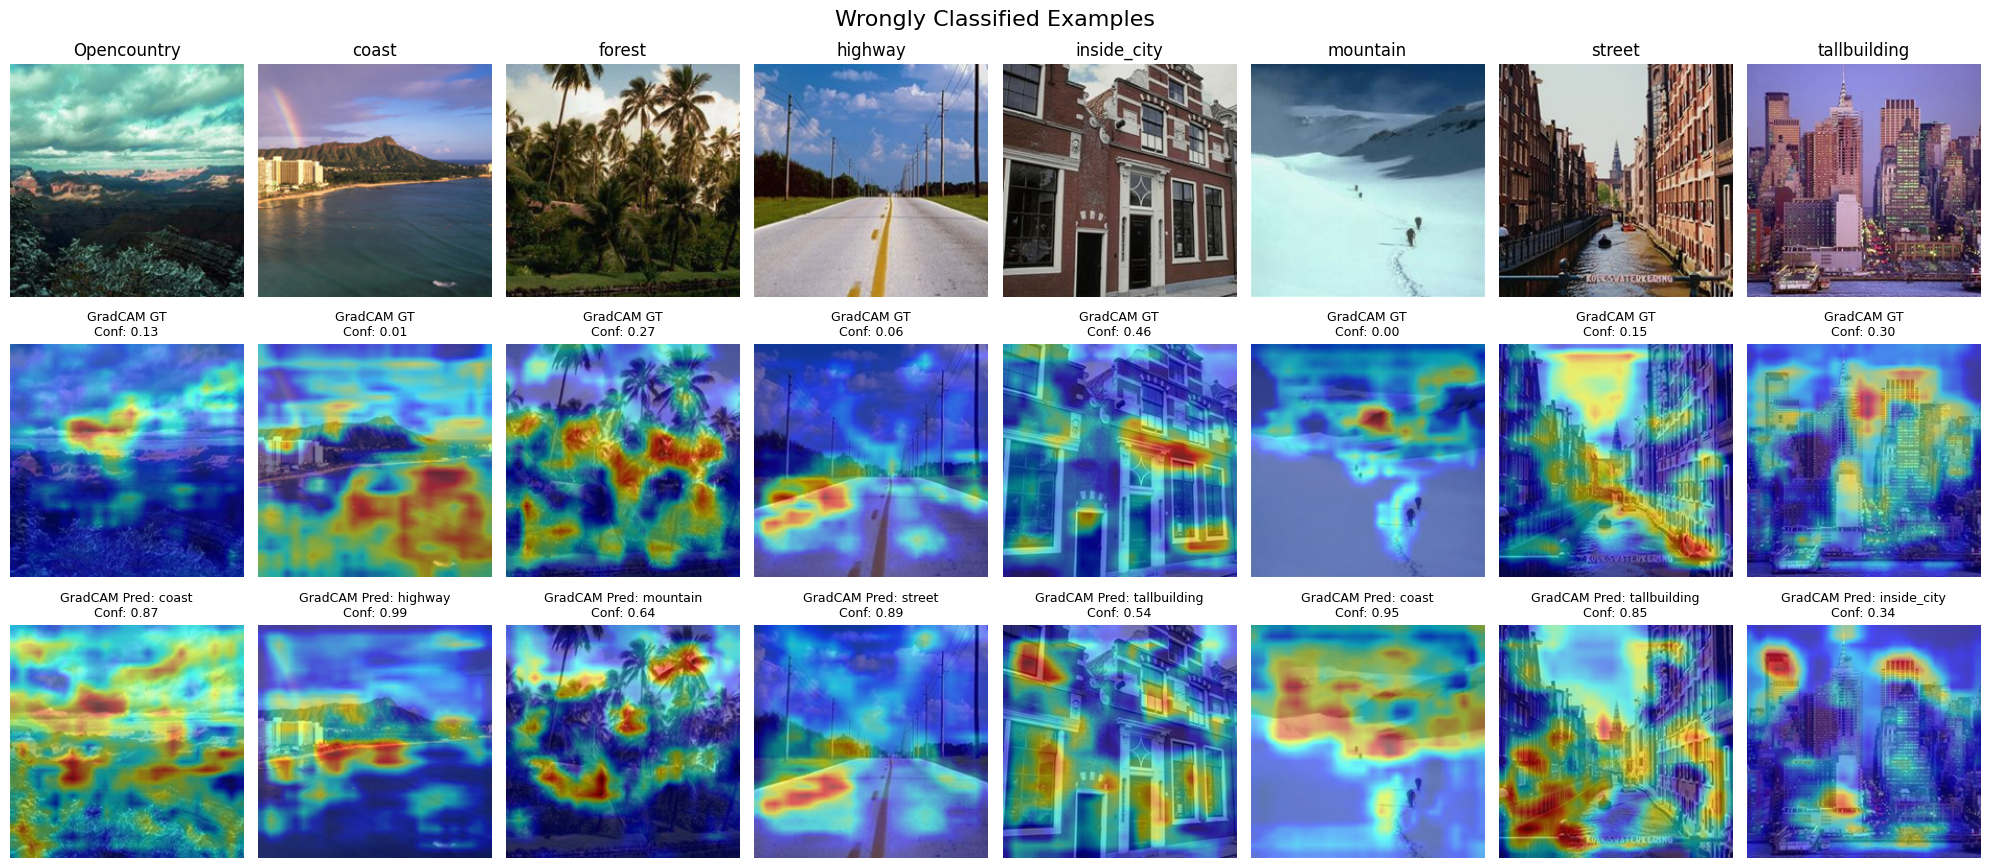

In [ ]:
misclassified_indices = [None] * len(data_test.classes)

for idx in range(len(data_test)):
    img_path, true_label = data_test.samples[idx]
    
    if misclassified_indices[true_label] is not None:
        continue
    
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transformation(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        predicted_class = output.argmax(1).item()
    
    if predicted_class != true_label:
        misclassified_indices[true_label] = idx
    
    if all(idx is not None for idx in misclassified_indices):
        break


misclassified_indices = [6, 362, 683, 948, 1164, 1420, 1742, 1992]


print("Selected indices per class:")
for class_id, idx in enumerate(misclassified_indices):
    if idx is not None:
        print(f"  Class {class_id} ({data_test.classes[class_id]}): index {idx}")




num_samples = len([idx for idx in misclassified_indices if idx is not None])
cols = num_samples
rows = 3  

fig, axes = plt.subplots(rows, cols, figsize=(2.5 * cols, 9))

if cols == 1:
    axes = axes.reshape(3, 1)

plot_idx = 0
for class_id, idx in enumerate(misclassified_indices):
    if idx is None:
        continue
    
    img_path, true_label = data_test.samples[idx]
    true_class_name = data_test.classes[true_label]
    
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transformation(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class = output.argmax(1).item()
        pred_confidence = probabilities[0, predicted_class].item()
        gt_confidence = probabilities[0, true_label].item()
    
    predicted_class_name = data_test.classes[predicted_class]
    
    img_array = np.array(img.resize((IMG_SIZE, IMG_SIZE)))
    img_normalized = img_array.astype(np.float32) / 255.0
    
    targets_gt = [ClassifierOutputTarget(true_label)]
    grad_cams_gt = model.extract_grad_cam(
        input_image=img_tensor,
        target_layer=target_layer,
        targets=targets_gt
    )
    visualization_gt = show_cam_on_image(img_normalized, grad_cams_gt, use_rgb=True)
    
    targets_pred = [ClassifierOutputTarget(predicted_class)]
    grad_cams_pred = model.extract_grad_cam(
        input_image=img_tensor,
        target_layer=target_layer,
        targets=targets_pred
    )
    visualization_pred = show_cam_on_image(img_normalized, grad_cams_pred, use_rgb=True)
    
    #original image
    axes[0, plot_idx].imshow(img_normalized)
    axes[0, plot_idx].set_title(f'{true_class_name}', fontsize=12)
    axes[0, plot_idx].axis('off')
    
    #gt class
    axes[1, plot_idx].imshow(visualization_gt)
    axes[1, plot_idx].set_title(f'GradCAM GT\nConf: {gt_confidence:.2f}', fontsize=9)
    axes[1, plot_idx].axis('off')
    
    #pred class
    axes[2, plot_idx].imshow(visualization_pred)
    axes[2, plot_idx].set_title(f'GradCAM Pred: {predicted_class_name}\nConf: {pred_confidence:.2f}', fontsize=9)
    axes[2, plot_idx].axis('off')
    
    plot_idx += 1

plt.suptitle('Wrongly Classified Examples', fontsize=16)
plt.tight_layout()
plt.show()

## Visualize GradCAM Evolution Across Network Blocks

Show how GradCAM activations evolve through different blocks of the network, from early to late layers.

Selected image: 1185
Predicted class: inside_city (confidence: 0.9774)


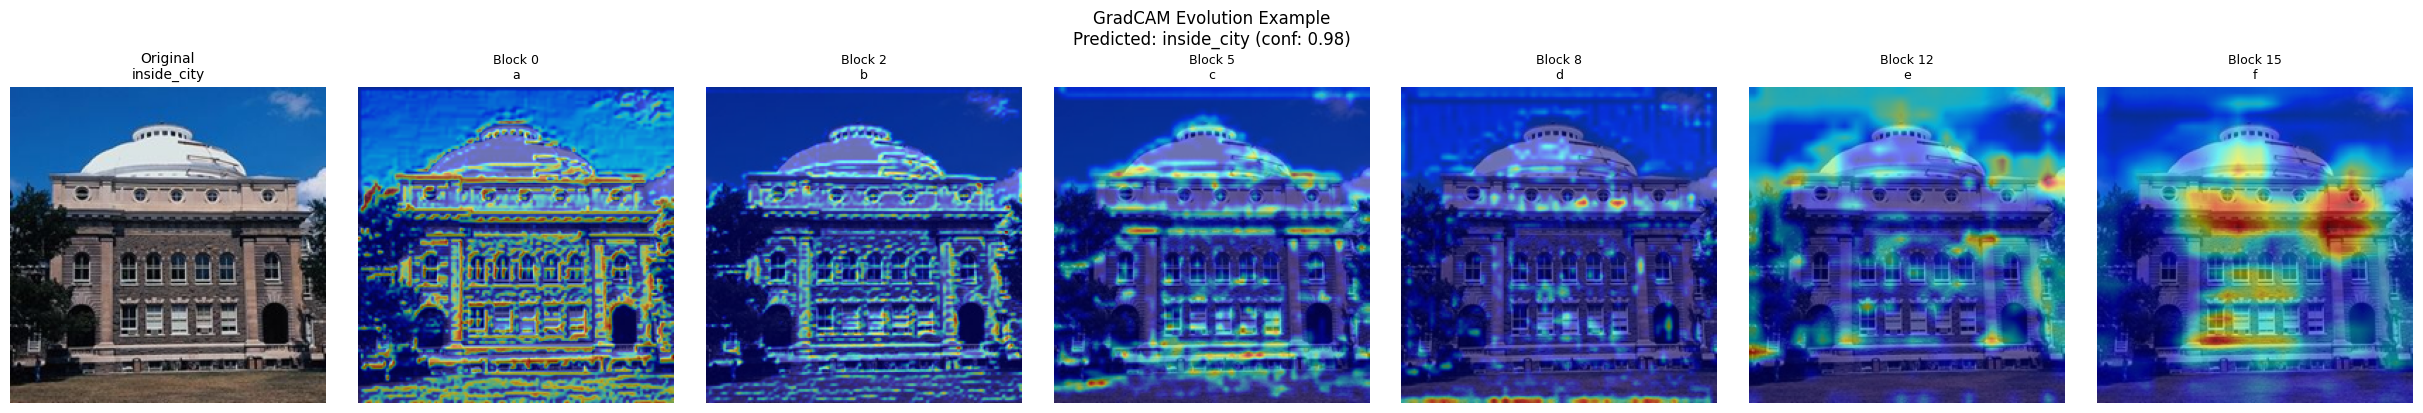

In [ ]:
idx = random.randint(0, len(data_test) - 1)
idx= 1185
img_path, label = data_test.samples[idx]
class_name = data_test.classes[label]

print(f"Selected image: {idx}")

img = Image.open(img_path).convert('RGB')
img_tensor = test_transformation(img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = output.argmax(1).item()
    confidence = probabilities[0, predicted_class].item()

predicted_name = data_test.classes[predicted_class]
print(f"Predicted class: {predicted_name} (confidence: {confidence:.4f})")


block_indices = [0, 2, 5, 8, 12, 15]
block_names = [
    'First Depthwise Conv',
    'Second Depthwise Conv',
    'Third Depthwise Conv',
    'Fourth Depthwise Conv',
    'Fifth Depthwise Conv',
    'Sixth Depthwise Conv'
]

# Prepare image for visualization
img_array = np.array(img.resize((IMG_SIZE, IMG_SIZE)))
img_normalized = img_array.astype(np.float32) / 255.0

# Create subplot: 1 original + N GradCAM visualizations
num_visualizations = len(block_indices) + 1
fig, axes = plt.subplots(1, num_visualizations, figsize=(3.5 * num_visualizations, 4))

# Show original image
axes[0].imshow(img_normalized)
axes[0].set_title(f'Original\n{class_name}', fontsize=10)
axes[0].axis('off')

# Generate and display GradCAM for each block
targets = [ClassifierOutputTarget(predicted_class)]

for i, (block_idx, block_name) in enumerate(zip(block_indices, block_names)):
    target_layer = [model.backbone[block_idx]]
    
    grad_cams = model.extract_grad_cam(
        input_image=img_tensor,
        target_layer=target_layer,
        targets=targets
    )
    
    visualization = show_cam_on_image(img_normalized, grad_cams, use_rgb=True)
    
    axes[i + 1].imshow(visualization)
    axes[i + 1].set_title(f'{block_name}', fontsize=9)
    axes[i + 1].axis('off')

plt.suptitle(f'GradCAM Evolution Example\nPredicted: {predicted_name} (conf: {confidence:.2f})', 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()